In [1]:
import json
from pydantic import BaseModel
from typing import List, Dict, Optional, Union, Literal
import sys 
import itertools
import seaborn

In [2]:
# Pydantic model definitions

class Item(BaseModel):
    id: int
    regName: str
    name: str
    displayName: str
    nbt: Optional[dict]

class Fluid(BaseModel):
    fluidName: str
    unlocalizedName: str
    luminosity: int
    density: int
    temperature: int
    viscosity: int
    isGaseous: bool
    rarity: str
    id: int
    
class GTFluid(Fluid):
    colorRGBA: List[int]
    localizedName: str
    fluidState: str

class RecipeStacks(BaseModel):
    items: Dict[str, Item]
    fluids: Dict[str, Union[Fluid, GTFluid]]

class MinimalItem(BaseModel):
    itemSlug: str
    count: int
    NBT: Optional[dict] = None
    
    def __hash__(self):
        return hash(self.itemSlug + str(self.count) + str(self.NBT))

class MinimalFluid(BaseModel):
    fluidSlug: str
    amount: int
    NBT: Optional[dict] = None
    
    def __hash__(self):
        return hash(self.fluidSlug + str(self.amount) + str(self.NBT))

# An item can be: a minimal item, minimal fluid (for FluidDisplays), or str
ItemSlot = Union[MinimalItem, MinimalFluid, str]
FluidSlot = MinimalFluid

class GenericRecipe(BaseModel):
    ingredients: List[ItemSlot]
    otherStacks: List[ItemSlot]
    outItem: Optional[ItemSlot] = None

class GregtechRecipe(BaseModel):
    # All items here should be nullable because some items are left as null to leave a space in the UI
    # Example: Cooking stuff (e.g. iron) in the primitive blast furnace.
    # It's (I think) safe to ignore them
    mInputs: List[Optional[ItemSlot]]
    mOutputs: List[Optional[ItemSlot]]
    mFluidInputs: List[Optional[FluidSlot]]
    mFluidOutputs: List[Optional[FluidSlot]]
    mDuration: int
    mEUt: int
    mSpecialValue: int
    mEnabled: bool
    mHidden: bool
    mFakeRecipe: bool
    mCanBeBuffered: bool
    mNeedsEmptyOutput: bool
    isNBTSensitive: bool
    metadataStorage: dict

class DumpedRecipe(BaseModel):
    generic: Optional[GenericRecipe] = None
    greg_data: Optional[GregtechRecipe] = None

class HandlerDump(BaseModel):
    recipes: List[DumpedRecipe]
    id: str
    name: str
    tab_name: str

class QueryDump(BaseModel):
    handlers: List[HandlerDump]
    query_item: ItemSlot

class DumpFile(BaseModel):
    version: str
    queries: List[QueryDump]

In [3]:
recipes_stacks_file = "data/recipes_stacks.json"
recipes_file = "data/recipes.json"

In [4]:
with open(recipes_stacks_file, "r", encoding="utf8") as f:
    recipe_stacks = RecipeStacks(**json.load(f))
    
with open(recipes_file, "r", encoding="utf8") as f:
    recipes = DumpFile(**json.load(f))

In [5]:
# My apologies to the RAM gods
print("stacks:", sys.getsizeof(recipe_stacks), "recipes:", sys.getsizeof(recipes))
# (oh yeah, I'd have to do recursive stuff. Naw that's what task manager is for)
# (or htop to you linux fools)

stacks: 80 recipes: 80


In [6]:

with open(recipes_file, "r", encoding="utf8") as f:
    r_json = json.load(f)
# First logged problem was here
query = r_json["queries"][468]
print(recipe_stacks.items[query["query_item"]])
print("num_handlers", len(query["handlers"]))
handler = query["handlers"][7]
print("Handler Name", handler["name"])
print("Num Recipes", len(handler["recipes"]))
recipe = handler["recipes"][0]["greg_data"]
print(recipe)
# Bruv how is that 
# also wtf is this recipe 
# print("Second item", recipe_stacks.items[recipe["mInputs"][1]], "fluid output", recipe_stacks.fluids[recipe["mFluidOutputs"][0]["fluidSlug"]])
# something is fucky, this recipe doesn't even return sand (spoilers, it was a random recipe, my dumping process was goofed)

id=265 regName='minecraft:iron_ingot' name='item.ingotIron' displayName='Iron Ingot' nbt={'id': '265S', 'Count': '1B', 'Damage': '0S'}
num_handlers 13
Handler Name Primitive Blast Furnace
Num Recipes 64
{'mInputs': [{'itemSlug': '4350d2548', 'count': 2}, None, {'itemSlug': '6918d0', 'count': 4}], 'mOutputs': [{'itemSlug': '265d0', 'count': 3}, None, {'itemSlug': '4350d815', 'count': 4}], 'mFluidInputs': [], 'mFluidOutputs': [], 'mDuration': 1600, 'mEUt': 0, 'mSpecialValue': 0, 'mEnabled': True, 'mHidden': False, 'mFakeRecipe': False, 'mCanBeBuffered': True, 'mNeedsEmptyOutput': False, 'isNBTSensitive': False, 'metadataStorage': {}}


In [7]:
print("version", recipes.version, "length", len(recipes.queries))

version 1.0-main.3+91e7d2b7a4-dirty length 32984


### To reduce size in memory and get things into a consistent format, do some processing.

Easy targets: 
- recipes that yield multiple products can be collapsed together
- recipes ingredients with multiple copies of the same product (e.g. shaped crafting) can be collapsed together
- there is a lot of extra metadata we won't use for this application, like GT "canBeBufferered" and other recipe annotations


TODO: To reduce memory insanity, do this filtering stream-style instead of reading the whole recipes file 

NOTE: Recipe_stacks is already small enough (relatively speaking lol) so I'mma leave it


In [8]:
# Target Format

# Treat Items+Fluids as equal citizens from now on
from functools import cached_property


class Stack(BaseModel):
    type: Literal["item", "fluid"]
    slug: str
    amount: int  # Count (items) or amount (fluids)
    
    @property
    def comboslug(self):
        return self.type+self.slug

    # Fricking awesome decorator
    # Obviously assumes you won't go changing recipe data around after loading (shouldn't be an issue?)
    # @cached_property
    def __hash__(self):
        # Intentionally do not hash amount so we can combine items with different amounts later
        return hash((self.type, self.slug))


class GregMeta(BaseModel):
    EUt: int
    ticks: int


class Recipe(BaseModel):
    inputs: List[Stack]
    outputs: List[Stack]
    machine: str  # aka crafing method/handler, includes e.g. Asemblers but also e.g. Shaped Crafting, etc.
    meta: Optional[GregMeta] = None

    # @cached_property
    def __hash__(self):
        # Intentionally leaving out meta stuff
        # TODO: Do recipes with same inputs/outputs but different processing times exist? If so, is it just overclocking (same recipe?)
        return hash((tuple(self.inputs), tuple(self.outputs), self.machine))

In [9]:
recipes_flat = lambda: itertools.chain(*(h.recipes for h in itertools.chain(*(q.handlers for q in recipes.queries))))
next(recipes_flat())

DumpedRecipe(generic=GenericRecipe(ingredients=['4d0'], otherStacks=['642d3'], outItem='1d0'), greg_data=None)

In [10]:
# Recipes with greg_data defined and mEnabled set to false
recipes_disabled = (r for r in recipes_flat() if (r.greg_data!=None and not r.greg_data.mEnabled))
recipes_hidden = (r for r in recipes_flat() if (r.greg_data!=None and  r.greg_data.mHidden))
# print("Disabled:", next(recipes_disabled)) # StopIteration
# print("Hidden", next(recipes_hidden)) # StopIteration
# so our user-side query returns neither disabled nor hidden recipes. Makes sense. That info can be thrown away np

<Axes: ylabel='Count'>

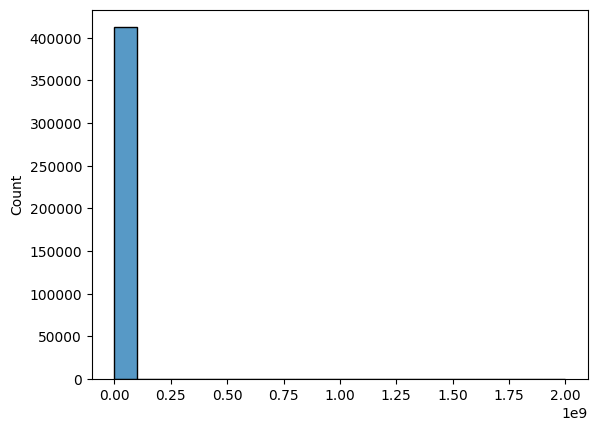

In [11]:
recipe_specialValues = [r.greg_data.mSpecialValue for r in recipes_flat() if r.greg_data!=None]
seaborn.histplot(recipe_specialValues)
# Interestingly, that's a lot of zeroes. Not very special. Can prolly throw this data away.
# (making executive decision to not look into any other fields here)

In [12]:
# do handlerID's uniquely identify tabNames?
handlers = {}
for query in recipes.queries:
    for handler in query.handlers:
        if (handler.id in handlers) and (handlers[handler.id]!=handler.tab_name):
            print(f"Overlapping handlerid->tab_name! Old: {handlers[handler.id]}, New: {handler.tab_name}")
            break
        handlers[handler.id] = handler.tab_name
# Answer: duh, of course not, the GT_NEI_DefaultHandler class does all sorts of GT recipes 
# (hence me adding a special case just to grab power info from it)
# We'll have to use tabNames as our hopefully-unique machine ID

Overlapping handlerid->tab_name! Old: Rock Breaker, New: Compressor
Overlapping handlerid->tab_name! Old: Rock Breaker, New: Forge Hammer
Overlapping handlerid->tab_name! Old: Rock Breaker, New: Cutting Machine
Overlapping handlerid->tab_name! Old: Rock Breaker, New: Cutting Machine
Overlapping handlerid->tab_name! Old: Rock Breaker, New: Cutting Machine
Overlapping handlerid->tab_name! Old: Rock Breaker, New: Cutting Machine
Overlapping handlerid->tab_name! Old: Rock Breaker, New: Cutting Machine
Overlapping handlerid->tab_name! Old: Rock Breaker, New: Cutting Machine
Overlapping handlerid->tab_name! Old: Rock Breaker, New: Tree Growth Simulator
Overlapping handlerid->tab_name! Old: Rock Breaker, New: Tree Growth Simulator
Overlapping handlerid->tab_name! Old: Rock Breaker, New: Tree Growth Simulator
Overlapping handlerid->tab_name! Old: Rock Breaker, New: Tree Growth Simulator
Overlapping handlerid->tab_name! Old: Rock Breaker, New: Tree Growth Simulator
Overlapping handlerid->tab_na

In [13]:
# recipes.queries = recipes.queries[:1000] # Trim for speedy testing

In [14]:
from typing import Sequence, Tuple

def stackify(itemSlot: ItemSlot) -> Stack:
    if isinstance(itemSlot, str):
        return Stack(type="item", slug=itemSlot, amount=1)
    elif isinstance(itemSlot, MinimalItem):
        return Stack(type="item", slug=itemSlot.itemSlug, amount=itemSlot.count)
    elif isinstance(itemSlot, MinimalFluid):
        return Stack(type="fluid", slug=itemSlot.fluidSlug, amount=itemSlot.amount)
    else:
        raise ValueError(f"Invalid itemSlot: {itemSlot} ({type(itemSlot)})")

def groupify(stacks: Sequence[Stack]) -> List[Stack]:
    groups = itertools.groupby(stacks, lambda stack: (stack.type, stack.slug))
    return [Stack(type=type, slug=slug, amount=sum(s.amount for s in stack_group)) for (type, slug), stack_group in groups]
    
def stackngroup(itemSlots: Sequence[Optional[ItemSlot]]):
    """
        Takes a list of itemSlots and returns a list of stacks, combining stacks with the same type and slug.
        This function throws away specific crafing recipes (e.g. (plank, plank, plank, plank) -> 1 crafting table) 
        in favor of a more compact, Satisfactory Tools-compatible format (e.g. 4 planks -> 1 crafting table)
    """
    stacks = [stackify(i) for i in itemSlots if i]
    return groupify(stacks)
    
final_recipes_set = set()
# Generic recipes must be built up before committing to the final recipes se
# because there can be a separate recipe for each output
generic_recipes: Dict[Tuple[Tuple, str], List] = {}
counter = 0
num_recipes = len(list(recipes_flat()))

for query in recipes.queries:
    for handler in query.handlers:
        for recipe in handler.recipes:
            assert recipe.generic or recipe.greg_data, "Recipe has neither generic nor greg_data"
            if counter % 100 == 0:
                print(f"Processing recipe {counter}/{num_recipes}", end="\r")
            counter += 1
            inputs = []
            outputs = []
            if recipe.generic:
                # For generic recipes, the otherStacks field is *usually* something like fuel or catalysts that are not consumed
                # This is a big assumption that is not always true.
                # However, if the recipe has no output, it's probably a handler that lists outputs in the otherStacks field
                # This is also a big assumption that is not always true.
                outputs = [stackify(recipe.generic.outItem)] if recipe.generic.outItem else stackngroup(recipe.generic.otherStacks)
                
                # Accumulate overlapping ingredients+handlers -> Multiple outputs
                # This assumes there are no duplicates of recipes that list outputs as otherStacks
                key = (tuple(recipe.generic.ingredients),handler.tab_name)
                generic_recipes[key] = generic_recipes.get(key, []) + outputs
            elif recipe.greg_data: 
                inputs = stackngroup(recipe.greg_data.mInputs + recipe.greg_data.mFluidInputs)
                outputs = stackngroup(recipe.greg_data.mOutputs + recipe.greg_data.mFluidOutputs)
                meta = GregMeta(EUt=recipe.greg_data.mEUt, ticks=recipe.greg_data.mDuration)
                # Greg recipes can be added directly as each copy of a recipe will be the same
                final_recipes_set.add(Recipe(
                    inputs=inputs,
                    outputs=outputs,
                    machine=handler.tab_name,
                    meta=meta
                ))

# Add generic recipes to final_recipes_set
final_recipes_set.update(Recipe(inputs=stackngroup(k[0]), outputs=groupify(v), machine=k[1]) for k, v in generic_recipes.items())

In [15]:
print("Recipes: Reduced", len(final_recipes_set), "Original", len(list(recipes_flat())))
original_items = sum(len(r.generic.ingredients) for r in recipes_flat() if r.generic) + sum(len(r.greg_data.mInputs) for r in recipes_flat() if r.greg_data)
reduced_items = sum(len(r.inputs) for r in final_recipes_set)
print("Items: Reduced", reduced_items, "Original", original_items)
# Not as dramatic as I anticipated.

Recipes: Reduced 159408 Original 479479
Items: Reduced 428482 Original 805102


In [16]:
# Print size of final_recipes_set
print("final_recipes_set:", sys.getsizeof(final_recipes_set))

final_recipes_set: 8388824


In [17]:
recipe_stacks.items["263d0"]

Item(id=263, regName='minecraft:coal', name='item.coal', displayName='Coal', nbt={'id': '263S', 'Count': '1B', 'Damage': '0S'})

In [19]:
list(final_recipes_set)[:10]

[Recipe(inputs=[Stack(type='item', slug='4350d17311', amount=1)], outputs=[Stack(type='item', slug='4350d11311', amount=1)], machine='Smelting', meta=None),
 Recipe(inputs=[Stack(type='item', slug='4355d12', amount=1), Stack(type='item', slug='470d8', amount=1)], outputs=[Stack(type='item', slug='470d9', amount=1)], machine='Shaped Crafting', meta=None),
 Recipe(inputs=[Stack(type='item', slug='4352d550', amount=1)], outputs=[Stack(type='item', slug='4350d2550', amount=16), Stack(type='item', slug='4350d32403', amount=1)], machine='Unpackager', meta=GregMeta(EUt=1, ticks=800)),
 Recipe(inputs=[Stack(type='item', slug='4355d190', amount=1), Stack(type='item', slug='6761d1', amount=1), Stack(type='item', slug='5465d0', amount=1), Stack(type='item', slug='7087d6', amount=1), Stack(type='item', slug='459d12', amount=1), Stack(type='item', slug='459d5144', amount=1), Stack(type='item', slug='4355d124', amount=1), Stack(type='item', slug='6761d1', amount=1), Stack(type='item', slug='5465d0',

In [20]:
import pickle
with open("data/final_recipes_set.pickle", "wb") as f:
    pickle.dump(final_recipes_set, f)